In [1]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 10.9 MB/s 


In [2]:
import mahotas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image, ImageOps
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix
from sklearn.ensemble import VotingClassifier

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### **Load Images and Extract TAS Descriptors**

In [4]:
image_dir = "/gdrive/My Drive/Project/Denoised_CLAHE_Cl3"

In [5]:
def load_data(tag='train'):
  tag_dir = os.path.join(image_dir, tag)
  tag_path = Path(tag_dir)
  data = [] # Images
  cat = [] # Category
  subcat = []
  patient = []
  file_name = []
  for mag_dir in tag_path.iterdir():  
    mag_label = mag_dir.stem
    print("*",mag_label)
    if mag_label == "400X":
      print("Got it!")
      for img_name in mag_dir.glob('*.png'):
        img_label = img_name.stem
        splitted_image_name = img_label.split('_')
        cat_label = splitted_image_name[1]
        remaining_part = splitted_image_name[2].split('-')
        subcat_label = remaining_part[0]
        patient_label = remaining_part[2]
        img = mahotas.imread(img_name.as_posix())
        img = img[:, :, 0]
        feature = mahotas.features.pftas(img)
        data.append(feature) # append the feature to the data
        cat.append(cat_label) # append the label to the category
        subcat.append(subcat_label)
        patient.append(patient_label)
        file_name.append(img_label)
  return data, cat, subcat, patient, file_name

In [6]:
# train images
vec_train, cat_train, subcat_train, patient_train, image_name_train = load_data('train')
# test images
vec_test, cat_test, subcat_test, patient_test, image_name_test = load_data('test')

* 40X
* 100X
* 200X
* 400X
Got it!
* 40X
* 100X
* 200X
* 400X
Got it!


### **List the Categories**

In [7]:
# Get unique categories for train data
labels = list(np.unique(np.array(cat_train))) # convert categories to the numpy array and get unique values
labels

['B', 'M']

In [8]:
# Get unique categories for test data
labels = list(np.unique(np.array(cat_test)))
labels

['B', 'M']

### **Label Encoding**

In [9]:
le = LabelEncoder()
label_train = le.fit_transform(cat_train) # Here fit is used to assign 0 or 1
label_test = le.transform(cat_test) # Only transform is used since the fit is already done above

In [10]:
label_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
label_test

### **Function to Compute Patient Recognition Rate**

In [12]:
def evaluate_recognition_rate(pred):
  inverted_prediction = le.inverse_transform(prediction)
  unique_patient_test = list(np.unique(np.array(patient_test)))
  num_images_per_patient = []
  num_correctly_classified = []
  num = 0
  total_patient_score = 0
  num_patient = 0
  for patient in unique_patient_test:
    num_patient = num_patient + 1
    Np = 0
    Nrec = 0
    image_index_counter = -1
    for image_name in image_name_test:
      image_index_counter = image_index_counter + 1
      image_name_splitted = image_name.split('-')
      if patient == image_name_splitted[2]:
        first_part_splitted = image_name_splitted[0].split('_')
        image_class = first_part_splitted[1]
        if image_class == inverted_prediction[image_index_counter]:
          Nrec = Nrec + 1
        Np = Np + 1
    patient_score = Nrec/Np
    #print(patient_score)
    num_images_per_patient.append(Np)
    num_correctly_classified.append(Nrec)
    total_patient_score = total_patient_score + patient_score
    num = num + Np    
  recognition_rate = total_patient_score/num_patient
  print("Summation of patient score: ", total_patient_score)
  print("Total Number of Patients: ", num_patient)
  print("Recognition Rate: ", recognition_rate)

### **Defining the Base Models and the Voting Ensemble**

In [13]:
# define the base models
models = list()

qda = Pipeline([("scale",StandardScaler()),('m', QuadraticDiscriminantAnalysis(reg_param = 0.2))])
models.append(('qda', qda))

adaboost = Pipeline([("scale",StandardScaler()), ('m', AdaBoostClassifier(n_estimators=100, random_state=42))])
models.append(('adaboost', adaboost))

knn = Pipeline ([("scale",StandardScaler()), ('m', KNeighborsClassifier(n_neighbors=1))])
models.append(('knn',knn))

randomforest = Pipeline([("scale",StandardScaler()), ('m', RandomForestClassifier(n_estimators = 50, random_state = 42))])
models.append(('randomforest', randomforest))

svc = Pipeline([("scale",StandardScaler()), ('m', SVC(probability=True, kernel = 'rbf', gamma = 'auto', C = 70))])
models.append(('svc', svc))

# define the voting ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')

### **Fit and Evaluate the Voting Ensemble**

In [14]:
ensemble.fit(vec_train,label_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


VotingClassifier(estimators=[('qda',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('m',
                                               QuadraticDiscriminantAnalysis(reg_param=0.2))])),
                             ('adaboost',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('m',
                                               AdaBoostClassifier(n_estimators=100,
                                                                  random_state=42))])),
                             ('knn',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('m',
                                               KNeighborsClassifier(n_neighbors=1))])),
                             ('randomforest',
                              Pipeline(steps=[('scale', StandardScaler()),
                         

**Accuracy**

Accuracy: 70.84%


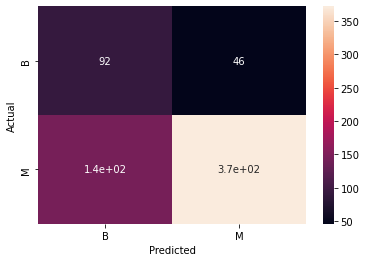

In [15]:
# Test set evaluation
prediction = ensemble.predict(vec_test)
# Visualization
cmat = confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [16]:
prediction_prob = ensemble.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.7250721741061514


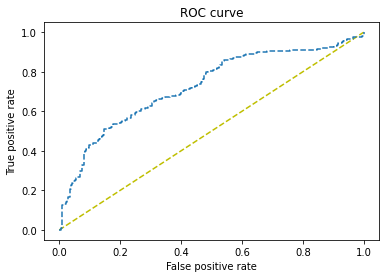

In [17]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [18]:
evaluate_recognition_rate(prediction)

Summation of patient score:  20.291778335725763
Total Number of Patients:  28
Recognition Rate:  0.724706369133063
